In [33]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [3]:

def pixelate_image(image, pixel_size):
    height, width = image.shape[:2]
    temp = cv2.resize(image, (pixel_size, pixel_size), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)


In [4]:

def pixelate_with_circles(image, circle_radius):
    output_image = image.copy()
    height, width = image.shape[:2]
    for y in range(0, height, circle_radius * 2):
        for x in range(0, width, circle_radius * 2):
            cv2.circle(output_image, (x + circle_radius, y + circle_radius), circle_radius, (0, 0, 0), -1)
    return output_image


In [23]:

def segment_image(image, circle_radius):
    segmented_image = np.zeros_like(image)
    height, width = image.shape[:2]
    region_colors = {}

    # Iterate through each circle region
    for y in range(0, height, circle_radius * 2):
        for x in range(0, width, circle_radius * 2):
            # Extract the region of interest
            roi = image[y:y+circle_radius*2, x:x+circle_radius*2]

            # Calculate the average color within the region
            average_color = np.mean(roi, axis=(0, 1))

            # Convert the average color to tuple for hashability
            average_color_tuple = tuple(average_color.astype(int))

            # Check if the color already exists in the dictionary
            if average_color_tuple in region_colors:
                color = region_colors[average_color_tuple]
            else:
                # Generate a random color for new regions
                color = np.random.randint(0, 256, (3,), dtype=np.uint8)
                region_colors[average_color_tuple] = color

            # Color the region with the assigned color
            cv2.circle(segmented_image, (x + circle_radius, y + circle_radius), circle_radius, color.tolist(), -1)

    return segmented_image

In [57]:

def segment_and_color(image, circle_radius):
    height, width = image.shape[:2]
    dark_color = (0, 0, 0)  # Dark color for background

    # Perform KMeans clustering to segment the image
    pixel_values = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
    kmeans.fit(pixel_values)
    segmented_image = kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape).astype(np.uint8)

    # Create a mask for the circles
    circle_mask = np.zeros((height, width), dtype=np.uint8)

    # Draw circles with random colors within each segmented region
    for cluster in range(kmeans.n_clusters):
        # Find pixels belonging to the current cluster
        cluster_mask = np.all(segmented_image == kmeans.cluster_centers_[cluster], axis=-1)

        # Generate a random color for the current cluster
        color = np.random.randint(0, 256, (3,), dtype=np.uint8)

        # Draw circles within the current cluster
        for y in range(0, height, circle_radius * 2):
            for x in range(0, width, circle_radius * 2):
                roi_mask = cluster_mask[y:y+circle_radius*2, x:x+circle_radius*2]
                if np.any(roi_mask):
                    cv2.circle(circle_mask, (x + circle_radius, y + circle_radius), circle_radius, 255, -1)
                    cv2.circle(image, (x + circle_radius, y + circle_radius), circle_radius, color, -1)

    # Darken the background where circles are not drawn
    #darkened_image = cv2.bitwise_and(image, image, mask=circle_mask)
    #darkened_image[darkened_image == 0] = dark_color

    return image

In [36]:

def find_similar_regions(image, threshold=50):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to find regions
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the regions
    mask = np.zeros_like(gray)

    # Draw contours on the mask
    for contour in contours:
        cv2.drawContours(mask, [contour], -1, (255), -1)

    return mask

def draw_random_circles(image, mask, circle_radius):
    output_image = np.zeros_like(image)

    height, width = image.shape[:2]

    # Iterate through the mask and draw circles
    for y in range(0, height, circle_radius * 2):
        for x in range(0, width, circle_radius * 2):
            if mask[y, x] == 255:  # Check if the pixel is part of a region
                # Generate a random color
                color = np.random.randint(50, 256, (3,), dtype=np.uint8)

                # Draw the circle with random color
                cv2.circle(output_image, (x + circle_radius, y + circle_radius), circle_radius, color.tolist(), -1)

    return output_image


In [107]:
img_path = "img2.png"

In [108]:

# Load the image
image = cv2.imread(img_path)  # Replace 'input_image.jpg' with your image path


In [58]:

# Set the parameters for pixelation
circle_radius = 4


In [18]:

# Pixelate the image
pixelated_image = pixelate_with_circles(image, circle_radius)


In [31]:
segmented_img = segment_image(image=image, circle_radius=circle_radius)

In [59]:
img = segment_and_color(image, circle_radius)

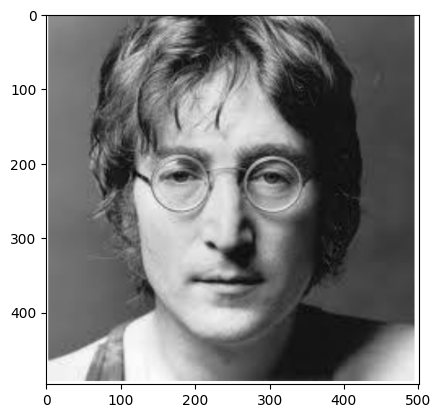

In [60]:
plt.imshow(img)

In [40]:
# Find similar regions in the image
mask = find_similar_regions(image)

# Draw random circles within similar regions
output_image = draw_random_circles(image, mask, circle_radius)

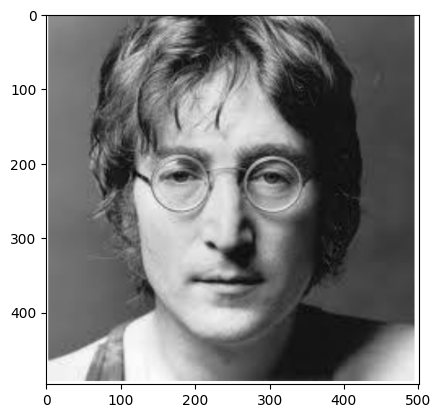

In [19]:

plt.imshow(image)


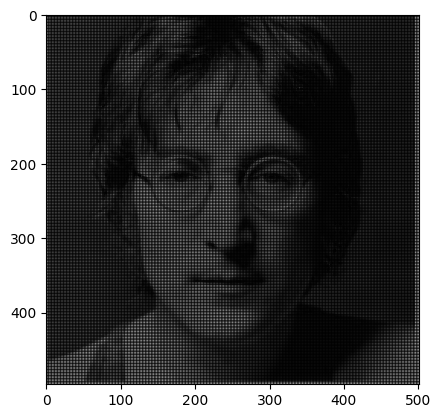

In [20]:
plt.imshow(pixelated_image)

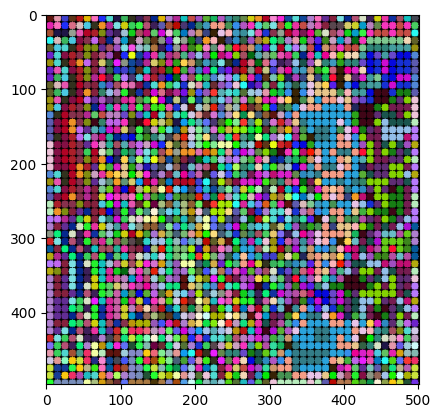

In [32]:
plt.imshow(segmented_img)

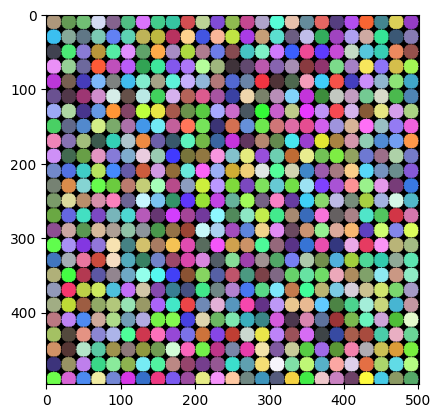

In [41]:
plt.imshow(output_image)

In [140]:
import random

def segment_image(image, num_clusters=5):
    # Reshape the image to 2D array of pixels
    reshaped_image = image.reshape((-1, 3))

    # Convert to float32
    reshaped_image = np.float32(reshaped_image)

    # Define criteria (epsilon, minimum number of iterations)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Perform k-means clustering
    _, labels, _ = cv2.kmeans(reshaped_image, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape back to original image shape
    segmented_image = labels.reshape(image.shape[:2])

    return segmented_image

def draw_random_circles(image, segmented_image, min_radius, max_radius):
    output_image = np.zeros_like(image, dtype=np.uint8)

    # Get unique labels (clusters)
    unique_labels = np.unique(segmented_image)

    # Create a mask to track occupied positions
    mask = np.zeros_like(segmented_image, dtype=bool)

    # Iterate through each cluster
    for label in unique_labels:
        # Select pixels belonging to the current cluster
        cluster_mask = (segmented_image == label)

        # Generate a random color for the circles within the cluster
        circle_color = np.random.randint(50, 256, (3,), dtype=np.uint8)

        # Draw circles within the cluster
        ys, xs = np.nonzero(cluster_mask)
        for y, x in zip(ys, xs):
            if not mask[y, x]:
                # Randomly select the radius for each circle within the specified range
                radius = random.randint(min_radius, max_radius)
                # Create a mask for the current circle
                circle_mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
                cv2.circle(circle_mask, (x, y), radius, 255, -1)
                # Draw the circle if the position is not occupied
                output_image[np.where(circle_mask)] = circle_color
                # Update the mask to mark the position as occupied
                mask[np.where(circle_mask)] = True

    return output_image


In [143]:

# Set the parameters
min_radius = 1
max_radius = 5
num_clusters = 5  # Number of clusters for k-means clustering

# Segment the image using k-means clustering
segmented_image = segment_image(image, num_clusters)

# Create a blank black canvas to draw circles on
output_image = np.zeros_like(image)

# Draw non-overlapping random circles with random sizes within the identified regions on the blank canvas
output_image_with_circles = draw_random_circles(image, segmented_image, min_radius, max_radius)


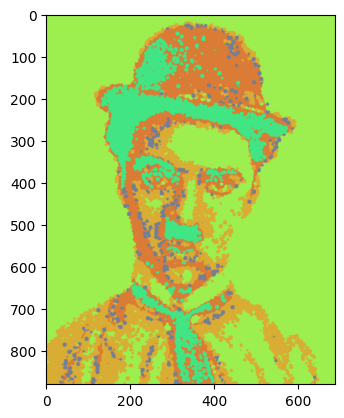

In [144]:
plt.imshow(output_image_with_circles)